# Assignment 3 - RBFs and LPMs
# Johannes M. Halkenhaeusser
# Minerva Schools at KGI
# CS156 - Prof. Sterne
# Spring 2020

In [32]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import numpy as np
import pandas as pd

from datetime import datetime
import time

In [19]:
###Adapted from 3.1 PCW code

years = range(2011, 2017)
files = ['CRNS0101-05-%d-CA_Yosemite_Village_12_W.txt' % y for y in years]

#I use the LST not the UTC because this will give us more insight into the actual time of day
usecols = [3, 4, 8]

data = [np.loadtxt(f, usecols=usecols) for f in files]
data = np.vstack(data)

In [12]:
#convert to data frame that is easier to work with
df = pd.DataFrame(data, columns = ['day_raw', 'minute_raw', 'temp'])

In [13]:
# Map from YYYYMMDD to day of year
df['year'] = [datetime.strptime(str(int(i)),'%Y%m%d').timetuple().tm_year for i in df['day_raw']]
df['day'] = [datetime.strptime(str(int(i)),'%Y%m%d').timetuple().tm_yday for i in df['day_raw']]
# Map from HHmm to an integer
df['min'] = np.floor_divide(df['minute_raw'], 100) * 60 + np.mod(df['minute_raw'], 100)

In [14]:
#there are some strange outlier values at -1000 degrees.
df = df[df['temp']> -1000]
#split into training and test
train = df[df['year'] < 2016]
test = df[df['year'] >= 2016]

In [15]:
#set up some alphas for the CV Ridge regression
alphas = [10**i for i in range(-8,2,1)]
print(alphas)

[1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]


In [16]:
#convert the data frame into arrays
x_day = np.asarray(train['day']).reshape(-1,1)
x_time = np.asarray(train['min']).reshape(-1,1)
y_s = np.asarray(train['temp']).reshape(-1, 1)

In [20]:
#see the baseline R^2 we are working with for the yearly

my_reg_yearly =  linear_model.RidgeCV(alphas = alphas)
my_reg_yearly.fit(x_day, y_s)
print("Score on training data = ", my_reg_yearly.score(x_day, y_s))

Score on training data =  0.03132506169887184


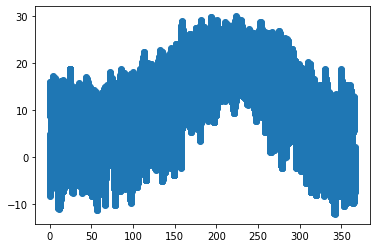

In [25]:
plt.scatter(x_day, y_s)

In [26]:
#see the baseline R^2 we are working with for the day
my_reg_daily =  linear_model.RidgeCV(alphas = alphas)
my_reg_daily.fit(x_day, y_s)
print("Score on training data = ", my_reg_daily.score(x_time, y_s))

Score on training data =  -1.234571644388005


Score on training data =  0.0016948111846561975


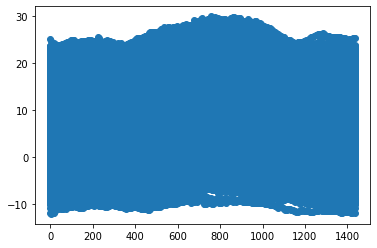

In [27]:
plt.scatter(x_time, y_s)
my_reg_daily =  linear_model.RidgeCV(alphas = alphas)
my_reg_daily.fit(x_time, y_s)
print("Score on training data = ", my_reg_daily.score(x_time, y_s))

In [28]:
my_reg_both =  linear_model.RidgeCV(alphas = alphas)
combined_data = np.concatenate((x_time, x_day), axis = 1)
my_reg_both.fit(combined_data, y_s)
print("Score on training data = ", my_reg_both.score(combined_data, y_s))

Score on training data =  -0.6427579914852715


As shown in the R^2 scores here, all 3 models are horrible right now. 

## Building the Models on the Training Data

In [29]:
## This function cross validates between the different centers and sigmas

def cross_val_RBFs(x_data, y_data, centers_numbers):
    
    no_trials = len(centers_numbers)*len(list(range(-3,7)))
    tab = np.zeros((no_trials, 3))
    trial = -1
    
    #loop through the different center numbers
    for no_centers in centers_numbers:
        
        
        #divide the data in the number of centers
        centers = np.linspace(min(x_data), max(x_data), no_centers)
    
        for exp in list(range(-2,6)):
            
            trial += 1
            
            
            #get a sigma (notice it being on log-scale)
            sigma = 10**exp
            
            #calculate the RBF(x) for each input
            x_data_rbf = rbf_kernel(x_data, centers, gamma=1 / sigma)

            #fit the regression
            my_reg_rbf =  linear_model.RidgeCV(alphas = alphas)
            my_reg_rbf.fit(x_data_rbf, y_data)
            
            
            #get an r-score
            r_score_new = my_reg_rbf.score(x_data_rbf, y_data)

            print(f"sigma of {sigma} has R^2 of: {r_score_new}")
            
            #record the outcome
            tab[trial] = no_centers, sigma, r_score_new
        
    return tab

### Variation Across a year.

In [30]:
#testing the RBF filters with monthly, weekly, and daily centers. 

out = cross_val_RBFs(x_day, y_s, [12, 52, 365])

sigma of 0.01 has R^2 of: 0.013899645080289846
sigma of 0.1 has R^2 of: 0.019646890117155702
sigma of 1 has R^2 of: 0.04099314234047102
sigma of 10 has R^2 of: 0.12536138621421322
sigma of 100 has R^2 of: 0.4083363959637405
sigma of 1000 has R^2 of: 0.5699487111192437
sigma of 10000 has R^2 of: 0.5678177942324645
sigma of 100000 has R^2 of: 0.5676446749708279
sigma of 0.01 has R^2 of: 0.06428257495021661
sigma of 0.1 has R^2 of: 0.09970713417537203
sigma of 1 has R^2 of: 0.2171264753610188
sigma of 10 has R^2 of: 0.5688317769746241
sigma of 100 has R^2 of: 0.5909739492996331
sigma of 1000 has R^2 of: 0.5827671136344141
sigma of 10000 has R^2 of: 0.5521574797086388
sigma of 100000 has R^2 of: 0.5659405111957692
sigma of 0.01 has R^2 of: 0.5607872802014501
sigma of 0.1 has R^2 of: 0.6214092996209652
sigma of 1 has R^2 of: 0.6213979982707742
sigma of 10 has R^2 of: 0.6205935113983169
sigma of 100 has R^2 of: 0.5481678712932867
sigma of 1000 has R^2 of: -3.568200077194253
sigma of 10000 ha

In [31]:
#the holy grail (i.e. the best combination of centers and sigmas I have found)
best_spec = out[:,2].argmax()
print(out[best_spec])
no_cen_best = out[best_spec][0]
sigma_best = out[best_spec][1]

[3.650000e+02 1.000000e-01 6.214093e-01]


The R^2 for day of the year is 0.6214093. 
We get this R^2 when we use a center per day with a sigma of 0.1.

In [34]:
## Represent the variation explained by the yearly component

centers = np.linspace(min(x_day), max(x_day), no_cen_best)
x_data_rbf = rbf_kernel(x_day, centers, gamma=1 / sigma_best)

#fit the regression
my_reg_rbf =  linear_model.RidgeCV(alphas = alphas)

start = time.time()
my_reg_rbf.fit(x_data_rbf, y_s)


print("It took", time.time() - start, "seconds to train this model")

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


It took 46.73881912231445 seconds to train this model


In [35]:
#Get 365 days for the entire year
fake_days = np.asarray(list(range(366))).reshape(-1,1)
fake_days_rbf = rbf_kernel(fake_days, centers, gamma=1/sigma_best)

y_hat = my_reg_rbf.predict(fake_days_rbf)

Text(0, 0.5, 'Temperature')

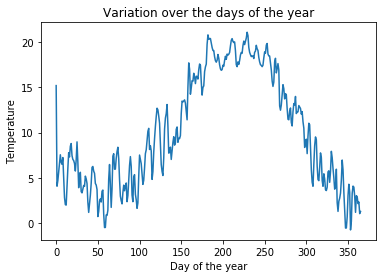

In [36]:
plt.plot(fake_days, y_hat)
plt.title("Variation over the days of the year")
plt.xlabel("Day of the year")
plt.ylabel("Temperature")

#### Note: There seems to be some overfitting here. This makes sense because there are a lot of centers. 

### Variation Across a day.

In [37]:
#testing RBF params for hourly, half-hour, and 5 minute centers

#The centers of the inputs of the RBF-filters for the time of day should be roughly every 5 minutes,
#because the time interval the measurements were taken was 5 minutes. 

out_daily_variation = cross_val_RBFs(x_time, y_s, [24, 48, 12*24])

sigma of 0.01 has R^2 of: 0.00040440598697522034
sigma of 0.1 has R^2 of: 0.0016859826840808223
sigma of 1 has R^2 of: 0.0037958314423880424
sigma of 10 has R^2 of: 0.005854894598718685
sigma of 100 has R^2 of: 0.017907390845124604
sigma of 1000 has R^2 of: 0.04389961510788376
sigma of 10000 has R^2 of: 0.0445354603580953
sigma of 100000 has R^2 of: 0.04452278016275024
sigma of 0.01 has R^2 of: 0.0012020104898856632
sigma of 0.1 has R^2 of: 0.0036363379687854858
sigma of 1 has R^2 of: 0.007678649638708013
sigma of 10 has R^2 of: 0.011865999629904755
sigma of 100 has R^2 of: 0.03585304032251335
sigma of 1000 has R^2 of: 0.04453521343306144
sigma of 10000 has R^2 of: 0.0445355505490751
sigma of 100000 has R^2 of: 0.04452163639823015
sigma of 0.01 has R^2 of: 0.04453507059419237
sigma of 0.1 has R^2 of: 0.04453507059419237
sigma of 1 has R^2 of: 0.044535070594192594
sigma of 10 has R^2 of: 0.044535670797806626
sigma of 100 has R^2 of: 0.04453608328817693
sigma of 1000 has R^2 of: 0.044535

In [38]:
#the holy grail (i.e. the best combination of centers and sigmas I have found)
best_spec_day = out_daily_variation[:,2].argmax()
print(out_daily_variation[best_spec_day])
no_cen_best_day = out_daily_variation[best_spec_day][0]
sigma_best_day = out_daily_variation[best_spec_day][1]

[2.88000000e+02 1.00000000e+02 4.45360833e-02]


The minutes during the day variation has an R^2 of: 4.45360833e-02
I.e. When in the day is less predictive than the day of the year. 
We get this when we use a 5 minute interval as center and a sigma of 10.

In [40]:
centers_day = np.linspace(min(x_time), max(x_time), no_cen_best_day)
x_data_rbf_day = rbf_kernel(x_time, centers_day, gamma=1 / sigma_best_day)

#fit the regression
my_reg_rbf_day =  linear_model.RidgeCV(alphas = alphas)


start_day = time.time()
my_reg_rbf_day.fit(x_data_rbf_day, y_s)
print("It took", time.time() - start_day, "seconds to train this model")

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


It took 35.68368887901306 seconds to train this model


In [41]:
#Get 365 days for the entire year
fake_minutes = np.asarray(list(range(24*60))).reshape(-1,1)
fake_minutes_rbf = rbf_kernel(fake_minutes, centers_day, gamma=1/sigma_best_day)

y_hat_minutes = my_reg_rbf_day.predict(fake_minutes_rbf)

Text(0, 0.5, 'Temperature')

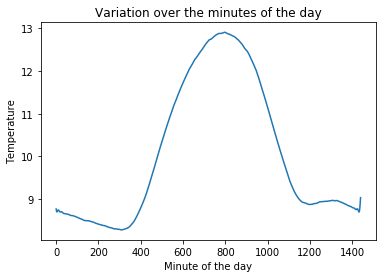

In [42]:
plt.plot(fake_minutes, y_hat_minutes)
plt.title("Variation over the minutes of the day")
plt.xlabel("Minute of the day")
plt.ylabel("Temperature")

### Train the full model

In [43]:
### Now that I have chosen the best specification to explain either variation let's see how the full model does. 
all_rbfs = np.concatenate((x_data_rbf, x_data_rbf_day), axis = 1)

full_model = linear_model.RidgeCV(alphas = alphas)

start_full = time.time()
full_model.fit(all_rbfs, y_s)
print("It took", time.time() - start_full, "seconds to train this model")

It took 88.7944929599762 seconds to train this model


In [44]:
full_model.score(all_rbfs, y_s)

0.6660796647992566

Yay! The combination of the two variations explains more variation than just using a single one.
This we should expect because we are combining our knowledge of both models. 

## Evaluate against Test Set

In [45]:
x_day_test = np.asarray(test['day']).reshape(-1,1)
x_time_test = np.asarray(test['min']).reshape(-1,1)
y_s_test = np.asarray(test['temp']).reshape(-1, 1)

#Get the RBF
test_yearly = rbf_kernel(x_day_test, centers, gamma=1/sigma_best)
test_daily = rbf_kernel(x_time_test, centers_day, gamma=1/sigma_best_day)
combined = np.concatenate((test_yearly, test_daily), axis = 1)


#Test the Models
## Note how I am using the models I have developed in the above sections
my_reg_rbf.score(test_yearly, y_s_test)
my_reg_rbf_day.score(test_daily, y_s_test)
full_model.score(combined, y_s_test)

0.5582328931945117

In [46]:
print(f"Using the variation across a year we get a test-data score of: \t {my_reg_rbf.score(test_yearly, y_s_test)}")
print(f"Using the variation across a day we get a test-data score of: \t {my_reg_rbf_day.score(test_daily, y_s_test)}")
print(f"Using the combined model we get a test-data score of: \t\t {full_model.score(combined, y_s_test)}")

Using the variation across a year we get a test-data score of: 	 0.5136254186462417
Using the variation across a day we get a test-data score of: 	 0.044118278343506456
Using the combined model we get a test-data score of: 		 0.5582328931945117


Like before the variation across the year contributes the most to explaining the variation in temperatures. Again combining the sets of RBFs helps us to get an even higher $R^2$. 

As expected above, the R^2 for the varation across a year drops much more than that across the day (even speaking in relative terms). This makes sense because when we look at how the days across the year explain temperature there is much stronger evidence of overfitting, whereas the variation across the minutes of the day is much smoother.

To improve on these scores even further, we could test more center-sigma combinations or use cross validation when deciding the center-sigma combinations. We could also throw more data on the model and include a parameter that accounts for the year that we are talking about (maybe some years are hotter than others). 